<a href="https://colab.research.google.com/github/minajm/diss_prep_initial/blob/main/dissertation_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Installing Prerequisites

In [ ]:
# !pip3 install mxnet-cu100

In [ ]:
# !pip3 install bert-embedding

In [ ]:
# !pip3 install sentence-transformers

# Improting Packages

In [2]:
import numpy as np
import pandas as pd
from numpy import save
from numpy import load
import seaborn as sns
import itertools
import random
import os
import re
import sys
from matplotlib import pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import ConfusionMatrixDisplay

from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score

from scipy.stats import shapiro
from scipy import stats 


# import mxnet as mx
# from bert_embedding import BertEmbedding
# from sentence_transformers import SentenceTransformer

In [ ]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('omw-1.4')
from nltk.tokenize import sent_tokenize, word_tokenize 
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer 
from nltk.corpus import wordnet
from nltk.tag import pos_tag

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


# Importing Dataset

In [2]:
d = pd.read_csv('top4games.csv')

In [5]:
d.head(2)

,Unnamed: 0,Unnamed: 0.1,app_id,app_name,review_id,language,review,timestamp_created,timestamp_updated,recommended,...,steam_purchase,received_for_free,written_during_early_access,author.steamid,author.num_games_owned,author.num_reviews,author.playtime_forever,author.playtime_last_two_weeks,author.playtime_at_review,author.last_played
0,7287921,7287922,252490,Rust,84790990,english,7DaysToDie is waaay better.,1610807318,1610807318,False,...,True,False,False,76561198100882147,422,120,24607.0,360.0,24404.0,1.610820e+09
1,7289651,7289652,252490,Rust,84708092,english,It's just the best of them,1610684730,1610684730,True,...,True,False,False,76561198027311238,210,15,113620.0,4.0,113620.0,1.610685e+09


In [16]:
sns.set_theme(style="whitegrid")
sns.set(rc={'figure.figsize':(11.7,8.27)})

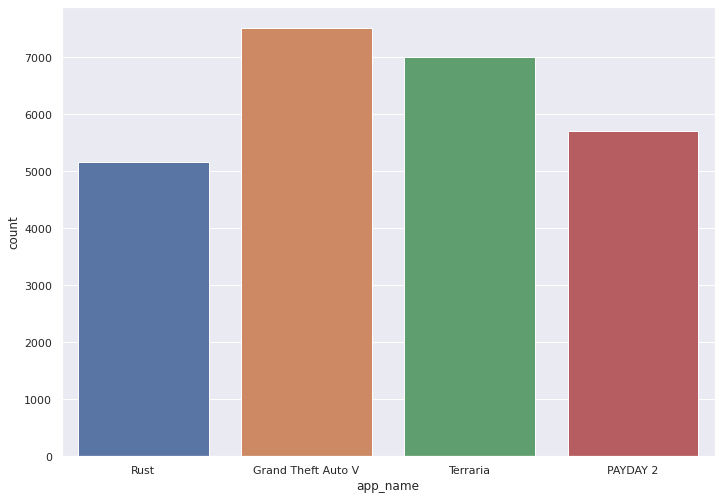

In [22]:
sns.countplot(data=d, x="app_name")

# Data Preparation

## Handling Missing Data

In [10]:
d=d.dropna()

In [11]:
d.shape

(25406, 24)

In [12]:
data = d.copy()

In [13]:
df_goal = data[['review', 'recommended']]

##Data Type Conversion

In [ ]:
df_goal['recommended'].replace({False: 0, True: 1}, inplace=True)

In [ ]:
df_goal['review'] = df_goal['review'].astype('str')
df_goal.dtypes

review         object
recommended     int64
dtype: object



## Data Splitting to Train & Test

After the extraction of the target data, it would be divided by train_test_split from Sklearn:

In [ ]:
# Spliting data to train & test by train_test_split
train_data, test_data = train_test_split(df_goal, test_size=0.2, random_state=42, shuffle=True)

In [ ]:
print('Train Data Shape Befor cleaning:',train_data.shape)
print('Test Data Shape Befor cleaning:',test_data.shape)

Train Data Shape Befor cleaning: (20324, 2)
Test Data Shape Befor cleaning: (5082, 2)


## Text Preprocessing


###Lowercasing, Removing of Punctuation & Fixing structural errors


In [ ]:
def ReviewCleaning(review):
    # Review prepration for TF-IDF, BERT & SBERT
    # Lowercasing
    review = review.strip().lower()
    review = re.sub(r'<.*?>', ' ', review)
    # Reforming contraction verbs in the review to their full forms
    review = re.sub(r"can't", "can not", review)
    review = re.sub(r"'ve", " have", review)
    review = re.sub(r"'re", " are", review)
    review = re.sub(r"n't", " not", review)
    review = re.sub(r"won't", "will not", review)
    review = re.sub(r"'ll", " will", review)
    
    # For TF-IDF
    if review_transfomer is not 'BERT_WS':
        # Eliminating numbers
        review = re.sub(r"[0-9]+", ' ', review)
        # Compound nouns containing hyphens were divided
        review = re.sub(r"-", ' ', review)
    
    # Placing a space instead of a punctuation mark for BERT and SBERT
    if review_transfomer is 'BERT_WS':
        punctuations='"#$%&*+<=>@[\\]^_`{|}~\t\n'
        # For the purpose of detecting the end of a sentence, these two marks were saved ("!"", "?"")
        review = re.sub(r'\!+', '!', review)
        review = re.sub(r'\?+', '?', review)
    else:
        # For TF-IDF
        punctuations='!"\'#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n'
    
    dict_trans = dict((w, " ") for w in punctuations)
    map_trans = str.maketrans(dict_trans)
    review = review.translate(map_trans)

    # For TF-IDF
    if review_transfomer is not 'BERT_WS':
        review = ' '.join([z for z in review.split() if len(z)>1])    
   
    # For BERT & SBERT
    if review_transfomer is 'BERT_WS':
        review = re.sub(r'\( *\)', ' ', review)

    # Multi-spaces that exist in review for TF-IDF, BERT & SBERT removed and replaced with a single space
    review = re.sub(' +', ' ', review)    
    review = ''.join(review)

    return review

#### Adding "clean_review" Column to Trian & Test Dataset

In [ ]:
review_transfomer = ''
train_data['prep_review'] = train_data['review'].apply(ReviewCleaning)
test_data['prep_review'] = test_data['review'].apply(ReviewCleaning)

### Stemming and Lemmatization
Adding 'clean_review_normalized' column to train & test dataset

In [ ]:
# Lemmatization & Stemming according to POS tagging
def POSTagNormLemStem(review):
    wordList = word_tokenize(review)
    stemm = PorterStemmer() 
    lemm = WordNetLemmatizer()
    rvw = []

    for word, tag in pos_tag(wordList):
        if tag.startswith('J'):
            w = lemm.lemmatize(word, pos='a')
        elif tag.startswith('V'):
            w = lemm.lemmatize(word, pos='v')
        elif tag.startswith('N'):
            w = lemm.lemmatize(word, pos='n')
        elif tag.startswith('R'):
            w = lemm.lemmatize(word, pos='r')
        else:
            w = word
        w = stemm.stem(w)
        rvw.append(w)
    
    Norm_review = ' '.join(rvw)
    return Norm_review

#### Adding "clean_review_normalized" Column to Trian & Test Dataset for TF-IDF

In [ ]:
train_data['prep_review_tfidf'] = train_data['prep_review'].apply(POSTagNormLemStem)
test_data['prep_review_tfidf'] = test_data['prep_review'].apply(POSTagNormLemStem)

### Removing Low Frequency words
Find words that have been repeated less than 5 times in the entire dataset.

In [ ]:
train_low_frq = pd.Series(' '.join(train_data['prep_review_tfidf']).split()).value_counts()
train_less5_frq = train_low_frq[(train_low_frq <5)]
test_low_frq = pd.Series(' '.join(test_data['prep_review_tfidf']).split()).value_counts()
test_less5_frq = test_low_frq[(test_low_frq <5)]

This effectively decreases the dimensions of TF-IDF vectors.

In [ ]:
train_data['prep_review_tfidf'] = train_data['prep_review_tfidf'].apply(
    lambda x: ' '.join(x for x in x.split() if x not in train_less5_frq))
test_data['prep_review_tfidf'] = test_data['prep_review_tfidf'].apply(
    lambda x: ' '.join(x for x in x.split() if x not in test_less5_frq))

#### Adding "clean_review_bert" to Train and Test Dataset for BERT & SBERT

In [ ]:
# For BERT and SBERT
review_transfomer = 'BERT_WS'
train_data['prep_review_bert_sbert'] = train_data['review'].apply(ReviewCleaning)
test_data['prep_review_bert_sbert'] = test_data['review'].apply(ReviewCleaning)

### Test of Cleaning Review


In [21]:
print("\nA review example of dataset before prperation and  cleaning:", end="\n\n")
print(train_data.iloc[4]['review'], end='\n\n\n')

print("Initial review prepration for TF-IDF, BERT & SBERT (prep_review):", end="\n\n")
print(train_data.iloc[4]['prep_review'], end="\n\n\n")

print("Review prepration for TF-IDF (prep_review_tfidf):", end="\n\n")
print(train_data.iloc[4]['prep_review_tfidf'], end="\n\n\n")

print("Review prepration for BERT & SBERT (prep_review_bert_sbert):", end="\n\n")
print(train_data.iloc[4]['prep_review_bert_sbert'], end="\n\n\n")


A review example of dataset before prperation and  cleaning:

This game is super toxic and it takes a lot of time to find a group who isnt toxic. unless youre playing on a pve server or with a group, dont.


Initial review prepration for TF-IDF, BERT & SBERT (prep_review):

this game is super toxic and it takes lot of time to find group who isnt toxic unless youre playing on pve server or with group dont


Review prepration for TF-IDF (prep_review_tfidf):

thi game be super toxic and it take lot of time to find group who isnt toxic unless your play on pve server or with group dont


Review prepration for BERT & SBERT (prep_review_bert_sbert):

this game is super toxic and it takes a lot of time to find a group who isnt toxic. unless youre playing on a pve server or with a group, dont.




### Final Cleaning

In [ ]:
nan_value = float("NaN")
train_data.replace("", nan_value, inplace=True)
train_data =train_data.dropna()

In [ ]:
nan_value = float("NaN")
test_data.replace("", nan_value, inplace=True)
test_data =test_data.dropna()

In [ ]:
print('Train Data Shape:',train_data.shape)
print('Test Data Shape:',test_data.shape)

Train Data Shape: (19841, 5)
Test Data Shape: (4929, 5)


In [ ]:
train_data['len'] = train_data['prep_review_tfidf'].map(lambda x: len(set(x)))

In [ ]:
train_data = train_data.drop(train_data[train_data['len'] < 3].index)

In [ ]:
test_data['len'] = test_data['prep_review_tfidf'].map(lambda x: len(set(x)))

In [ ]:
test_data = test_data.drop(test_data[test_data['len'] < 3].index)

In [ ]:
print('Final Train Data Shape:',train_data.shape)
print('Final Test Data Shape:',test_data.shape)

Final Train Data Shape: (19517, 6)
Final Test Data Shape: (4849, 6) 4849


## Save Final Train & Test Data For Modeling Part

In [14]:
train_data.to_csv('train.csv')
test_data.to_csv('test.csv')

# Improting Train & Test Data

In [4]:
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

In [1]:
# train_data.head(2)

In [2]:
# test_data.head(2)

# TFIDF, BERT & SBERT Text Transformer + SVM Classifier

## Text Transformer

### TFIDF

In [7]:
review_transfomer = 'TFIDF'
vectorizer = TfidfVectorizer(ngram_range=(1, 2), max_features=16000)

tfidf_features_train = vectorizer.fit_transform(train_data["prep_review_tfidf"])    
tfidf_features_test = vectorizer.transform(test_data["prep_review_tfidf"])

In [8]:
print("tfidf_features_train",tfidf_features_train.shape)
print("tfidf_features_train",tfidf_features_test.shape)

tfidf_features_train (19517, 16000)
tfidf_features_train (4849, 16000)


### BERT & SBERT

In [ ]:
ctx = mx.cpu(0)
bert = BertEmbedding(ctx=ctx)

Vocab file is not found. Downloading.


In [ ]:
# Cleaning before BERT
review_transfomer = 'BERT'

In [ ]:
# for using BERT & SBERT
def MeanBertSBERT(i): 
    return sum(itertools.chain(i))/len(i)

In [ ]:
bert_transformers = SentenceTransformer('bert-base-nli-mean-tokens')

Downloading:   0%|          | 0.00/391 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/3.95k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/625 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/122 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/438M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/399 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/229 [00:00<?, ?B/s]

In [ ]:
def embeddToBERT(text):
    sentences = re.split('!|\?|\.',text)
    sentences = list(filter(None, sentences)) 

    if bert_version == 'WORD':
        result = bert(sentences, 'avg')
    
        bert_vocabs_of_sentence = []
        for sentence in range(len(result)):
            for word in range(len(result[sentence][1])):
                bert_vocabs_of_sentence.append(result[sentence][1][word])
        feature = [MeanBertSBERT(x) for x in zip(*bert_vocabs_of_sentence)]

    elif bert_version == 'SENTENCE':
        result = bert_transformers.encode(sentences)
        feature = [MeanBertSBERT(x) for x in zip(*result)]

    return np.asarray(feature).reshape((768,1))

#### BERT (Word Transformer)

In [ ]:
bert_version = 'WORD'

bert_features_train=[]
for i in train_data['prep_review_bert_sbert']:
    bert_features_train.append(embeddToBERT(i))


In [ ]:
bert_features_train1 = bert_features_train

In [ ]:
feature = [x for x in bert_features_train1]
bert_features_train1 = np.asarray(feature).reshape(len(train_data),768)

In [ ]:
# save to npy file
save('bert_features_train1.npy', bert_features_train1)

In [ ]:
bert_version = 'WORD'

bert_features_test=[]
for i in test_data['prep_review_bert_sbert']:
    bert_features_test.append(embeddToBERT(i))

In [ ]:
bert_features_test1= bert_features_test

In [ ]:
feature = [x for x in bert_features_test1]
bert_features_test1 = np.asarray(feature).reshape(len(test_data),768)

In [ ]:
# save to npy file
save('bert_features_test1.npy', bert_features_test1)

In [9]:
# load array
bert_features_train_new = load('bert_features_train1.npy')
bert_features_test_new = load('bert_features_test1.npy')

# print the array
print(bert_features_train_new.shape)
print(bert_features_test_new.shape)

(19517, 768)
(4849, 768)


####  SBERT (Sentence Transformer)

In [ ]:
bert_version = 'SENTENCE'

sbert_features_train=[]
for i in train_data['prep_review_bert_sbert']:
    sbert_features_train.append(embeddToBERT(i))

19516

In [ ]:
sbert_features_train1 = sbert_features_train

In [ ]:
feature = [x for x in sbert_features_train1]
sbert_features_train1 = np.asarray(feature).reshape(len(train_data),768)

In [ ]:
# save to npy file
save('sbert_features_train1.npy', sbert_features_train1)

In [ ]:
bert_version = 'SENTENCE'

sbert_features_test=[]
for i in test_data['prep_review_bert_sbert']:
    sbert_features_test.append(embeddToBERT(i))

4848

In [ ]:
sbert_features_test1= sbert_features_test

In [ ]:
feature = [x for x in sbert_features_test1]
sbert_features_test1 = np.asarray(feature).reshape(len(test_data),768)

In [ ]:
# save to npy file
save('sbert_features_test1.npy', sbert_features_test1)

In [10]:
# load array
sbert_features_train_new = load('sbert_features_train1.npy')
sbert_features_test_new = load('sbert_features_test1.npy')

# print the array
print(sbert_features_train_new.shape)
print(sbert_features_test_new.shape)

(19517, 768)
(4849, 768)


## SVM Modeling 

In [112]:
# A function to plot and print result
def modelEval(y_pred, y_prob):
    acc = accuracy_score(test_data["recommended"], y_pred)
    fi = f1_score(test_data["recommended"], y_pred)
    percision = precision_score(test_data["recommended"], y_pred)
    recall = recall_score(test_data["recommended"], y_pred)
    
    print ('',end='\n\n')
    print("Accuracy Percent: {:.2f} %".format(acc *100),end='\n')
    print("Accuracy: {:.4f}".format(acc *100),end='\n')
    print("f1 score: {:.4f}".format(fi),end='\n')
    print("precision score: {:.4f}".format(percision),end='\n')
    print("recall score: {:.4f}".format(recall),end='\n\n\n')
    
    print ('Classification Report:',end='\n\n')
    print(classification_report(test_data["recommended"],y_pred),end='\n\n')


    print ('Confusion Matrix',end='\n\n')
    cmatrix = confusion_matrix(test_data["recommended"],y_pred)
    group_names = ['True Neg','False Pos','False Neg','True Pos']

    group_counts = ["{0:0.0f}".format(value) for value in
                cmatrix.flatten()]

    group_percentages = ["{0:.2%}".format(value) for value in
                        cmatrix.flatten()/np.sum(cmatrix)]

    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
              zip(group_names,group_counts,group_percentages)]

    labels = np.asarray(labels).reshape(2,2)

    ax = sns.heatmap(cmatrix, annot=labels, fmt='', cmap='Blues')

    ax.set_title('Confusion Matrix\n\n');
    ax.set_xlabel('\nPredicted Values')
    ax.set_ylabel('Actual Values ');

    ## Ticket labels - List must be in alphabetical order
    ax.xaxis.set_ticklabels(['False','True'])
    ax.yaxis.set_ticklabels(['False','True'])

    ## Display the visualization of the Confusion Matrix.
    plt.show()   


In [14]:
model = SVC(kernel ='linear', C = 1)

### TFIDF + SVM

In [16]:
model_svm_tfidf = SVC(kernel ='linear', C = 1)

In [17]:
# Training 
model_svm_tfidf.fit(tfidf_features_train, train_data["recommended"])

In [ ]:
# Evaluation
y_pred_tfidf_stop_svm = model_svm_tfidf.predict(tfidf_features_test)
y_prob_tfidf_stop_svm = model_svm_tfidf.decision_function(tfidf_features_test)



Accuracy Percent: 87.50 %
Accuracy: 87.5026
f1 score: 0.9216
precision score: 0.8986
recall score: 0.9459


Classification Report:

              precision    recall  f1-score   support

           0       0.77      0.63      0.69      1081
           1       0.90      0.95      0.92      3768

    accuracy                           0.88      4849
   macro avg       0.83      0.79      0.81      4849
weighted avg       0.87      0.88      0.87      4849


Confusion Matrix



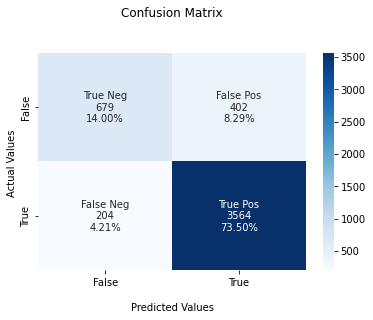

In [113]:
# Result
modelEval(y_pred_tfidf_stop_svm, y_prob_tfidf_stop_svm)

In [ ]:
results_svm_tfidf = []
kfold = RepeatedStratifiedKFold(n_splits=10, n_repeats = 3, random_state=1)
results_svm_tfidf = cross_val_score(model_svm_tfidf, tfidf_features_train, train_data["recommended"], 
                                    cv=kfold, scoring='accuracy') 

In [ ]:
np.save('results_svm_tfidf.npy', results_svm_tfidf)

In [39]:
results_svm_tfidf1 = np.load('results_svm_tfidf.npy')

In [87]:
mean1 = results_svm_tfidf1.mean()
std1 =  results_svm_tfidf1.std()
p_mean1 = print("Mean Acurracy: {:.2f} %".format(mean1 *100),end='\n')
p_std1 = print("STD Acurracy: {:.4f}".format(std1 ),end='\n')


Mean Acurracy: 88.21 %
STD Acurracy: 0.0060


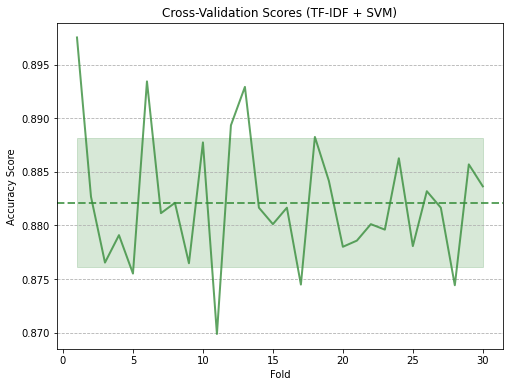

In [40]:
# create a figure
fig1, ax1 = plt.subplots(figsize=(8, 6))

# compute the mean and standard deviation of the scores
mean_scores_tfidf = np.mean(results_svm_tfidf1)
std_scores_tfidf = np.std(results_svm_tfidf1)

# create a line plot of the scores
ax1.plot(range(1, len(results_svm_tfidf1)+1), results_svm_tfidf1, color='#378D3B', linewidth=2, alpha=0.8)

# add the mean as a horizontal line
ax1.axhline(mean_scores_tfidf, color='#378D3B', linestyle='--', linewidth=2, alpha=0.8)

# add the standard deviation as a transparent band around the mean line
ax1.fill_between(range(1, len(results_svm_tfidf1)+1), mean_scores_tfidf - std_scores_tfidf, mean_scores_tfidf + std_scores_tfidf, color='#378D3B', alpha=0.2)

# add grid lines
ax1.grid(axis='y', linestyle='--')

# add plot title and axis labels
ax1.set_title("Cross-Validation Scores (TF-IDF + SVM)")
ax1.set_xlabel("Fold")
ax1.set_ylabel("Accuracy Score")

# show the plot
plt.show()

### BERT + SVM

In [24]:
model_svm_bert = SVC(kernel ='linear', C = 1)

In [25]:
# Training 
model_svm_bert.fit(bert_features_train_new, train_data["recommended"])

# Evaluation
y_pred_bert_svm = model_svm_bert.predict(bert_features_test_new)
y_prob_bert_svm = model_svm_bert.decision_function(bert_features_test_new)



Accuracy Percent: 84.06 %
Accuracy: 84.0586
f1 score: 0.8998
precision score: 0.8794
recall score: 0.9212


Classification Report:

              precision    recall  f1-score   support

           0       0.67      0.56      0.61      1081
           1       0.88      0.92      0.90      3768

    accuracy                           0.84      4849
   macro avg       0.78      0.74      0.75      4849
weighted avg       0.83      0.84      0.84      4849


Confusion Matrix



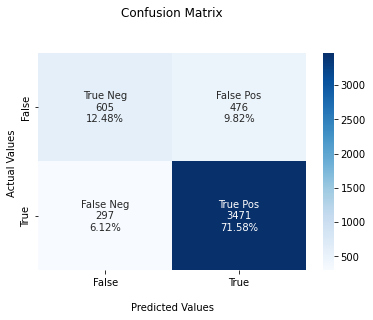

In [114]:
modelEval(y_pred_bert_svm, y_prob_bert_svm)

In [ ]:
results_svm_bert = []
kfold_bert = RepeatedStratifiedKFold(n_splits=10, n_repeats = 3, random_state=1)
results_svm_bert = cross_val_score(model_svm_bert, bert_features_train_new, train_data["recommended"], 
                                   cv=kfold_bert, scoring='accuracy') 

In [ ]:
np.save('results_svm_bert.npy', results_svm_bert)

In [33]:
results_svm_bert1 = np.load('results_svm_bert.npy')

In [88]:
mean2 = results_svm_bert1.mean()
std2 =  results_svm_bert1.std()
p_mean2 = print("Mean Acurracy: {:.2f} %".format(mean2 *100),end='\n')
p_std2 = print("STD Acurracy: {:.4f}".format(std2 ),end='\n')

Mean Acurracy: 85.71 %
STD Acurracy: 0.0064


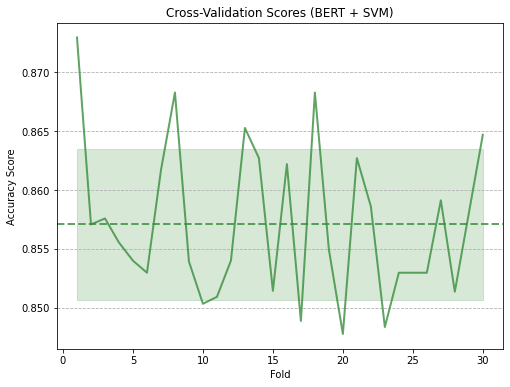

In [37]:
# create a figure
fig2, ax2 = plt.subplots(figsize=(8, 6))

# compute the mean and standard deviation of the scores
mean_scores_bert = np.mean(results_svm_bert1)
std_scores_bert = np.std(results_svm_bert1)

# create a line plot of the scores
ax2.plot(range(1, len(results_svm_bert1)+1), results_svm_bert1, color='#378D3B', linewidth=2, alpha=0.8)

# add the mean as a horizontal line
ax2.axhline(mean_scores_bert, color='#378D3B', linestyle='--', linewidth=2, alpha=0.8)

# add the standard deviation as a transparent band around the mean line
ax2.fill_between(range(1, len(results_svm_bert1)+1), mean_scores_bert - std_scores_bert, mean_scores_bert + std_scores_bert, color='#378D3B', alpha=0.2)

# add grid lines
ax2.grid(axis='y', linestyle='--')

# add plot title and axis labels
ax2.set_title("Cross-Validation Scores (BERT + SVM)")
ax2.set_xlabel("Fold")
ax2.set_ylabel("Accuracy Score")

# show the plot
plt.show()

### SBERT + TFIDF

In [54]:
# Training 
model_svm_sbert = SVC(kernel ='linear', C = 1)

In [55]:
# Training 
model_svm_sbert.fit(sbert_features_train_new, train_data["recommended"])

# Evaluation
y_pred_sbert_svm = model_svm_sbert.predict(sbert_features_test_new)
y_prob_sbert_svm = model_svm_sbert.decision_function(sbert_features_test_new)



Accuracy Percent: 86.18 %
Accuracy: 86.1827
f1 score: 0.9123
precision score: 0.8998
recall score: 0.9252


Classification Report:

              precision    recall  f1-score   support

           0       0.71      0.64      0.67      1081
           1       0.90      0.93      0.91      3768

    accuracy                           0.86      4849
   macro avg       0.81      0.78      0.79      4849
weighted avg       0.86      0.86      0.86      4849


Confusion Matrix



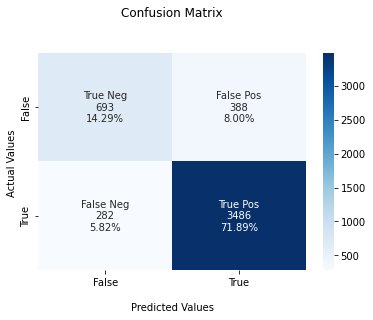

In [115]:
modelEval(y_pred_sbert_svm, y_prob_sbert_svm)

In [ ]:
results_svm_sbert = []
kfold_sbert = RepeatedStratifiedKFold(n_splits=10, n_repeats = 3, random_state=1)
results_svm_sbert = cross_val_score(model_svm_sbert, sbert_features_train_new, train_data["recommended"], 
                                    cv=kfold_sbert, scoring='accuracy') 

In [ ]:
np.save('results_svm_sbert.npy', results_svm_sbert)

In [4]:
results_svm_sbert1 = np.load('results_svm_sbert.npy')

In [5]:
results_svm_sbert1

array([0.88268443, 0.87141393, 0.87295082, 0.86526639, 0.85758197,
       0.87295082, 0.86987705, 0.87237314, 0.86519733, 0.86160943,
       0.86629098, 0.86577869, 0.87858607, 0.87243852, 0.86372951,
       0.86731557, 0.85758197, 0.87749872, 0.87596105, 0.86468478,
       0.87141393, 0.86577869, 0.86321721, 0.87295082, 0.86987705,
       0.86577869, 0.87653689, 0.86417222, 0.87237314, 0.87544849])

In [86]:
mean3 = results_svm_sbert1.mean()
std3 =  results_svm_sbert1.std()
p_mean3 = print("Mean Acurracy: {:.2f} %".format(mean3 *100),end='\n')
p_std3= print("STD Acurracy: {:.4f}".format(std3 ),end='\n')

Mean Acurracy: 86.93 %
STD Acurracy: 0.0060


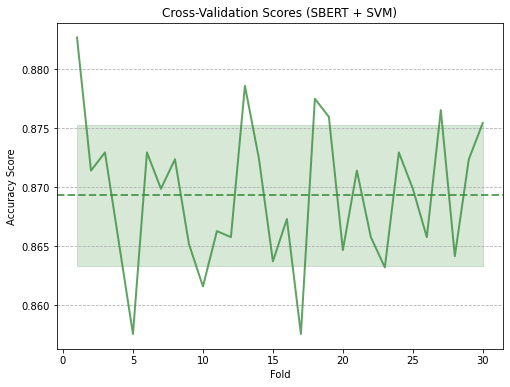

In [36]:
# create a figure
fig3, ax3 = plt.subplots(figsize=(8, 6))

# compute the mean and standard deviation of the scores
mean_scores_sbert = np.mean(results_svm_sbert1)
std_scores_sbert = np.std(results_svm_sbert1)

# create a line plot of the scores
ax3.plot(range(1, len(results_svm_sbert1)+1), results_svm_sbert1, color='#378D3B', linewidth=2, alpha=0.8)

# add the mean as a horizontal line
ax3.axhline(mean_scores_sbert, color='#378D3B', linestyle='--', linewidth=2, alpha=0.8)

# add the standard deviation as a transparent band around the mean line
ax3.fill_between(range(1, len(results_svm_sbert1)+1), mean_scores_sbert - std_scores_sbert, mean_scores_sbert + std_scores_sbert, color='#378D3B', alpha=0.2)

# add grid lines
ax3.grid(axis='y', linestyle='--')

# add plot title and axis labels
ax3.set_title("Cross-Validation Scores (SBERT + SVM)")
ax3.set_xlabel("Fold")
ax3.set_ylabel("Accuracy Score")

# show the plot
plt.show()


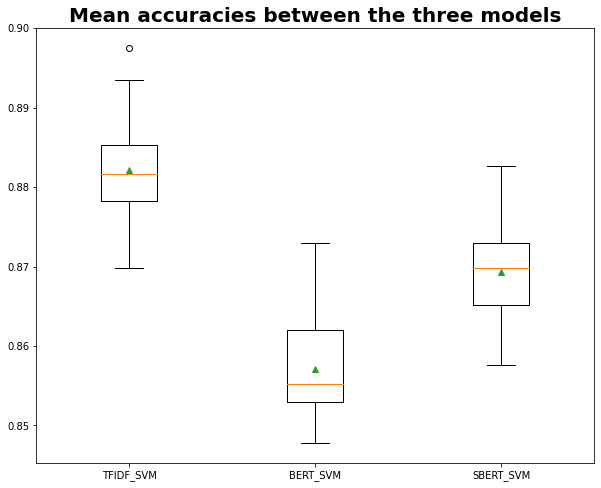

In [98]:
import matplotlib.pyplot as plt
plt.figure(figsize = (10, 8))
plt.grid(False)
plt.title("Mean accuracies between the three models", fontsize = 20, fontweight = 'bold')
plt.boxplot([results_svm_tfidf1,results_svm_bert1, results_svm_sbert1], labels=['TFIDF_SVM', 'BERT_SVM', 'SBERT_SVM'], showmeans=True)
plt.show()

### Normality Test 


**Shapiro-Wilk test on the normally distributed of 10 fold Cross validation of each model scores**

* H0: Sample is from the normal distributions.(Po>0.05)
* H1: Sample is not from the normal distributions.



In [ ]:
# TF-IDF + SVM

shapiro(results_svm_tfidf1)

ShapiroResult(statistic=0.9711730480194092, pvalue=0.5717493295669556)

H0 is accepted as Pvalue is bigger than of 0.05. the scores are normal 

In [ ]:
# BERT + SVM

shapiro(results_svm_bert1)

ShapiroResult(statistic=0.9446528553962708, pvalue=0.12140970677137375)

H0 is accepted as Pvalue is bigger than of 0.05. the scores are normal 

In [ ]:
# SBERT +SVM

shapiro(results_svm_sbert1)

ShapiroResult(statistic=0.9749371409416199, pvalue=0.680877149105072)

H0 is accepted as Pvalue is bigger than of 0.05. the scores are normal 

### Student t-test for Hypothesis Acceptance and Rejection

TFIDF, BERT

In [ ]:
tfidf_svm_acc_scor_bar, bert_svm_acc_scor_bar = np.mean(results_svm_tfidf1), np.mean(results_svm_bert1)
print("TFIDF_SVM acuracy scores mean:",np.round(tfidf_svm_acc_scor_bar,4))
print("BERT_SVM acuracy scores mean:",np.round(bert_svm_acc_scor_bar,4))

n1, n2 = len(results_svm_tfidf1), len(results_svm_bert1)

var_tfidf_svm_acc_scor_bar, var_bert_svm_acc_scor_bar= np.var(results_svm_tfidf1, ddof=1), np.var(results_svm_bert1, ddof=1)
print("variance of TFIDF_SVM acuracy scores:",np.round(var_tfidf_svm_acc_scor_bar,4))
print("variance of BERT_SVM acuracy scores:",np.round(var_bert_svm_acc_scor_bar,4))

# Calculating pooled sample variance & standard error
var_tfidf_bert = ( ((n1-1)*var_tfidf_svm_acc_scor_bar) + ((n2-1)*var_bert_svm_acc_scor_bar) ) / (n1+n2-2)
std_error_tfidf_bert = np.sqrt(var_tfidf_bert * (1.0 / n1 + 1.0 / n2))
print("pooled sample variance:",var_tfidf_bert)
print("standard error:",std_error_tfidf_bert)

TFIDF_SVM acuracy scores mean: 0.8821
BERT_SVM acuracy scores mean: 0.8571
variance of TFIDF_SVM acuracy scores: 0.0
variance of BERT_SVM acuracy scores: 0.0
pooled sample variance: 3.990334972277346e-05
standard error: 0.0016310191031534743


In [ ]:
# Calculating of t-static
t = abs(tfidf_svm_acc_scor_bar - bert_svm_acc_scor_bar) / std_error_tfidf_bert
print('t static:',t)

# Calculating two-tailed & one-tailed critical value at alpha = 0.05
t_c = stats.t.ppf(q=0.975, df=12)
t_c = stats.t.ppf(q=0.95, df=12)
print("Critical value for t two tailed:",t_c)
print("Critical value for t one tailed:",t_c)

# Calculating two-tailed & one-tailed p-value
p_two = 2*(1-stats.t.cdf(x=t, df=12))
 
# Calculating two-tailed & one-tailed p-value
p_one = 1-stats.t.cdf(x=t, df=12)
print("p-value for two tailed:",p_two)
print("p-value for one tailed:",p_one)

t static: 15.361583982012796
Critical value for t two tailed: 2.1788128296634177
Critical value for t one tailed: 1.782287555649159
p-value for two tailed: 2.958851386125616e-09
p-value for one tailed: 1.479425693062808e-09


In [3]:
pval_tfidf_bert = 2.958851386125616e-09
stat_tfidf_bert = 15.361583982012796

print("p-value for two tailed TF_IDF and BERT: {:.4f}".format(pval_tfidf_bert),end='\n')
print("T Static for two tailed TF_IDF and BERT: {:.4f}".format(stat_tfidf_bert),end='\n')

p-value for two tailed TF_IDF and BERT: 0.0000
T Static for two tailed TF_IDF and BERT: 15.3616


In [7]:
if pval_tfidf_bert < 0.05:
  print('H0 is accepted ')
else:
  print('H0 is rejected')


H0 is accepted 


TFIDF , SBERT

In [ ]:
tfidf_svm_acc_scor_bar, sbert_svm_acc_scor_bar = np.mean(results_svm_tfidf1), np.mean(results_svm_sbert1)
print("TFIDF_SVM acuracy scores mean:",np.round(tfidf_svm_acc_scor_bar,4))
print("SBERT_SVM acuracy scores mean:",np.round(sbert_svm_acc_scor_bar,4))

n1, n2 = len(results_svm_tfidf1), len(results_svm_sbert1)

var_tfidf_svm_acc_scor_bar, var_sbert_svm_acc_scor_bar= np.var(results_svm_tfidf1, ddof=1), np.var(results_svm_sbert1, ddof=1)
print("variance of TFIDF_SVM acuracy scores:",np.round(var_tfidf_svm_acc_scor_bar,4))
print("variance of SBERT_SVM acuracy scores:",np.round(var_sbert_svm_acc_scor_bar,4))

# Calculating pooled sample variance & standard error
var_tfidf_sbert = ( ((n1-1)*var_tfidf_svm_acc_scor_bar) + ((n2-1)*var_sbert_svm_acc_scor_bar) ) / (n1+n2-2)
std_error_tfidf_sbert = np.sqrt(var_tfidf_sbert * (1.0 / n1 + 1.0 / n2))
print("pooled sample variance:",var_tfidf_sbert)
print("standard error:",std_error_tfidf_sbert)

TFIDF_SVM acuracy scores mean: 0.8821
SBERT_SVM acuracy scores mean: 0.8693
variance of TFIDF_SVM acuracy scores: 0.0
variance of SBERT_SVM acuracy scores: 0.0
pooled sample variance: 3.733580696894729e-05
standard error: 0.0015776735397191079


In [ ]:
# Calculating of t-static
t = abs(tfidf_svm_acc_scor_bar - sbert_svm_acc_scor_bar) / std_error_tfidf_sbert
print('t static:',t)

# Calculating two-tailed & one-tailed critical value at alpha = 0.05
t_c = stats.t.ppf(q=0.975, df=12)
t_c = stats.t.ppf(q=0.95, df=12)
print("Critical value for t two tailed:",t_c)
print("Critical value for t one tailed:",t_c)
 
# Calculating two-tailed & one-tailed p-value
p_two = 2*(1-stats.t.cdf(x=t, df=12)) 
p_one = 1-stats.t.cdf(x=t, df=12)
print("p-value for two tailed:",p_two)
print("p-value for one tailed:",p_one)

t static: 8.12991570387337
Critical value for t two tailed: 2.1788128296634177
Critical value for t one tailed: 1.782287555649159
p-value for two tailed: 3.1870260888133828e-06
p-value for one tailed: 1.5935130444066914e-06


In [1]:
pval_tfidf_sbert = 3.1870260888133828e-06
stat_tfidf_sbert = 8.12991570387337

print("p-value for two tailed TF_IDF and SBERT: {:.4f}".format(pval_tfidf_sbert),end='\n')
print("T Static for two tailed TF_IDF and SBERT: {:.4f}".format(stat_tfidf_sbert),end='\n')

p-value for two tailed TF_IDF and SBERT: 0.0000
T Static for two tailed TF_IDF and SBERT: 8.1299


In [6]:
if pval_tfidf_sbert < 0.05:
  print('H0 is accepted ')
else:
  print('H0 is rejected')


H0 is accepted 


 <table style="width:100%">
  <tr>
    <th>Rank</th>
    <th>Text Transformer + Classifier</th>
    <th>Mean Accuracy (10-fold Cross Val) %</th>
  </tr>
  <tr>
    <td>1</td>
    <td>TFIDF + SVM</td>
    <td bgcolor="">88.21 %</td>
  </tr>
  <tr>
    <td>2</td>
    <td>SBERT (Sentence Embedding) + SVM</td>
    <td bgcolor="">86.93 %</td>
  </tr>
  <tr>
    <td>3</td>
    <td>BERT (Word Embedding) + SVM</td>
    <td>85.71 %</td>
  </tr>
</table> 